In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import os
import re
import yaml
import sys
import subprocess
import math
import glob
import time
import random
from statistics import mean

In [2]:
from AstraWrapper.SettingsFile import SettingsFile
from AstraWrapper.Astra import Astra

In [35]:
setFile = SettingsFile("parallelBeam")
astra = Astra(setFile)

# Parallel focusing 
This is python code written in jupyter notebook which implements different methods for point-point to parallel-parallel focusing. It uses software ASTRA, a program to simulate beam dynamics in accelerators. Programs in this notebook run in the same directory as are the ASTRA executables, mainly generator and Astra. 

The initial information are regarding the input file to Astra and information about reference particles. I used 5 different reference particles to determine the focusing properties of a setup- the first particle with 0 offset and 0 angle, moving along the z axis. This particle should not move in the transverse direction. Next 2 particles would be with initial offsets in the x and y directions respectively, but because this is point-point focusing, I am not using these. Last 2 have angles in the x and y direction respectively.

The magnets that are used are permanent quadrupole magnets with set gradients, lengths and bore diameters. These parameters can be changed, but for now they are set to values of 3 quadrupole magnets in LLR laboratory. The variables which will be changing are distances between them and the initial momentum. D1 is the distance from the source to the 1. quadrupole magnet. Realistically, D1 is only up to fringe fields which are magnetic fields outside the magnet's bores (reach 3*bore size in ASTRA). This option can be changed using TopHatShapedQuads() function. D2 and D3 are distances between first 2 and last 2 magnets in sequence. Last variable that can be changed is the initial longitudinal momentum of particles.

For running beam simulations, one can define it's initial parameters like spread of transverse momenta, spread of longitudinal energy, spread of offsets in the x and y directions as well as in the longitudinal direction. Also number of initial particles, space charge, secondary particle emission or other parameters can be changed in file parallelBeam.in.


In [36]:
def funcMin(D3,D1, D2, D4, momZ):
    
    dataCurrent = astra.runRef(D1,D2, D3[0], D4,None, momZ, False)
    if dataCurrent == 1:
        return 1E+9
    sumX = astra.parallelFocusing(dataCurrent)

    print(D3[0]*1e+2, sumX)

    return sumX

In [37]:
def func(D1, D2,D3, D4, momZ, switcher):
    
    dataCurrent = astra.runRef(D1,D2, D3, D4,None, momZ, False)
    if dataCurrent == 1:
        return 1E+9
    sumX = astra.parallelFocusing(dataCurrent)
    
    print(D3*1e+2, sumX)

    D3vals[switcher].append(D3*1e+2)
    funcVals[switcher].append(sumX)
    
    return sumX

In [42]:
def studyOfMaxStep(inputFile):
    # with this junk, i studied the different step size at Astra, function below plots the results
    Dmin = [0.0]
    Dmax = [1.]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    with open(inputFile, "r") as file:
        input = file.readlines()
    
    
    setups = []
    for line in input:
        line = line.replace("\n","")
        line = line.split(" ")  
        num = [float(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])]
        setups.append(num)
    
    '''
    
    results = [[],[]]
    for setup in setups:
        time1 = time.time()
        #res = sc.optimize.minimize(func, (0.1, 0.1),method="COBYLA", bounds=bounds,tol=1e-4, args=(setup[0],setup[3], setup[4] ))
        print(runRef(*setup, False))
        time2 = time.time()
        #plotRefXY3(setup[0], *res.x, setup[3], setup[4], f"solution: {res.x}")
        print(f"Timing: {time2 - time1}")
        break
        
        
        results[0] = list(D3vals)
        results[1] = list(funcVals)
        D3vals.clear()
        funcVals.clear()
    
        plt.scatter(results[0], results[1], label=methods[0] + " tol=1e-4")
        plt.xlabel("D3 [cm]")
        plt.ylabel("f(D3) [mrad^2]")
        plt.xlim(0,15)
        plt.ylim(0,1)
        plt.legend()
        plt.show()
        plt.scatter(results[0], results[1], label=methods[0] + " tol=1e-4")
        plt.scatter(results[2], results[3], label=methods[1] + " tol=1e-4")
        plt.scatter(results[4], results[5], label=methods[2] + " tol=1e-4")
        plt.xlabel("D3 [cm]")
        plt.ylabel("f(D3) [mrad^2]")
        plt.xlim(7.25,7.4)
        plt.ylim(0,0.00001)
    '''    
    astra.quadType(1)

    res = sc.optimize.minimize( funcMin, (0.2),method="Powell", tol=1e-7, bounds=bounds, args=(setups[0][0], setups[0][1], setups[0][3], setups[0][4])) 

    setups[0][2] = res.x[0]
    
    timings = []
    Hmax = [0.005, 0.001, 0.0005, 0.0001]
    for h in Hmax:
        setFile.changeInputData("H_max",str(h))
        time1 = time.time()
        for i in range(100):
            D3 = (res.x[0]*100 - 0.075 +i*0.15/100)/100
            if h == 0.005:
                resX= func(setups[0][0], setups[0][1],D3,setups[0][3],setups[0][4], 0)
            elif h == 0.001:
                resX= func(setups[0][0], setups[0][1],D3,setups[0][3],setups[0][4], 1)
            elif h == 0.0005:
                resX= func(setups[0][0], setups[0][1],D3,setups[0][3],setups[0][4],2)
            elif h == 0.0001:
                resX= func(setups[0][0], setups[0][1],D3,setups[0][3],setups[0][4],3)
        
        time2 = time.time()
        timings.append(time2 -time1)
        print(timings)
        '''
        plt.scatter(D3vals, funcVals, label="x angle")
        plt.xlabel("D3 [cm]")
        plt.ylabel("f(D3) [mrad^2]")
        plt.xlim(7.25,7.4)
        plt.ylim(0,0.0002)
        
        plt.legend()
        plt.show()
        
        
        plt.plot(D3vals, funcVals, label="x angle")
        plt.xlabel("D3 [cm]")
        plt.ylabel("f(D3) [mrad^2]")
        plt.xlim(7.25,7.4)
        plt.ylim(0,0.0001)
        
        plt.legend()
        plt.show()
        '''
    #proc.stdin.close()
    #proc.wait()  # This waits for the shell process to terminate

In [43]:
D3vals = [[],[],[],[]]
funcVals = [[],[],[],[]]
studyOfMaxStep("../backup/inputLists/maxStepStudy.txt")

20.0 1.071295643125
38.19660112501051 6.54141240625
61.803398874989476 20.54722289
23.60679774997897 1.7870528406250001
7.629788003845955 0.000269130774625
7.632575603565739 0.00026909917981250003
7.631991187674185 0.0002690984123125
7.632169008233888 0.000269100701
7.631149646335265 0.00026909640812499997
7.630629545184875 0.00026912735225000003
7.631471086523795 0.0002690940503125
7.631506678617943 0.000269089779625
7.6316917446095704 0.00026909078125
7.631594449894398 0.0002690884560625
7.631586363043298 0.00026909590981250004
7.6315979666808325 0.000269092085
7.631590933107963 0.0002690921828125
0.0 0.406715940625
61.80339887498949 20.54722289
38.19660112501052 6.54141240625
23.606797749978973 1.7870528406250001
7.629788003845962 0.000269130774625
7.632575603565737 0.00026909917981250003
7.63199118767419 0.0002690984123125
7.632169008233889 0.000269100701
7.631149646335271 0.00026909640812499997
7.630629545184882 0.00026912735225000003
7.6314710865238 0.0002690940503125
7.631506678

IndexError: list index out of range

In [49]:
def plotStepStudy():
    plt.scatter(D3vals[0], funcVals[0], label="H_max = 0.005 ns, t = 6.6 s")
    plt.scatter(D3vals[1], funcVals[1], label="H_max = 0.001 ns, t = 15.0 s")
    plt.scatter(D3vals[2], funcVals[2], label="H_max = 0.0005 ns, t = 25.1 s")
    #plt.scatter(D3vals[3], funcVals[3], label="H_max = 0.0001 ns, t = 111.1 s")
    plt.xlabel("D3 [cm]")
    plt.ylabel("f(D3) [mrad^2]")
    #plt.xlim(7.25,7.4)
    #plt.ylim(0,0.0002)
    
    plt.legend()
    plt.show()
    
    
    plt.plot(D3vals[0], funcVals[0], label="H_max = 0.005 ns, t = 6.6 s")
    plt.plot(D3vals[1], funcVals[1], label="H_max = 0.001 ns, t = 15.0 s")
    plt.plot(D3vals[2], funcVals[2], label="H_max = 0.0005 ns, t = 25.1 s")
    #plt.plot(D3vals[3], funcVals[3], label="H_max = 0.0001 ns, t = 111.1 s")
    plt.xlabel("D3 [cm]")
    plt.ylabel("f(D3) [mrad^2]")
    #plt.xlim(7.25,7.4)
    #plt.ylim(0,0.0002)
    
    plt.legend()
    plt.show()

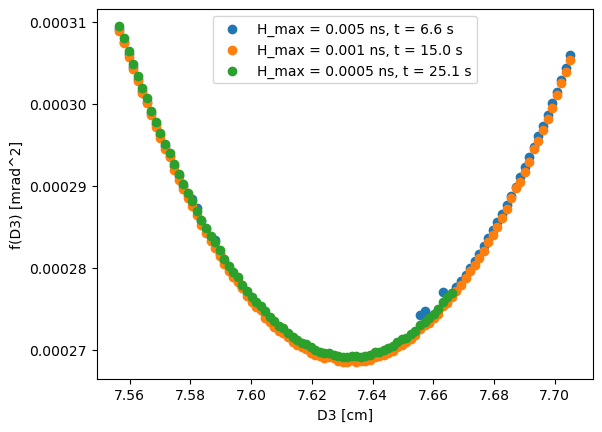

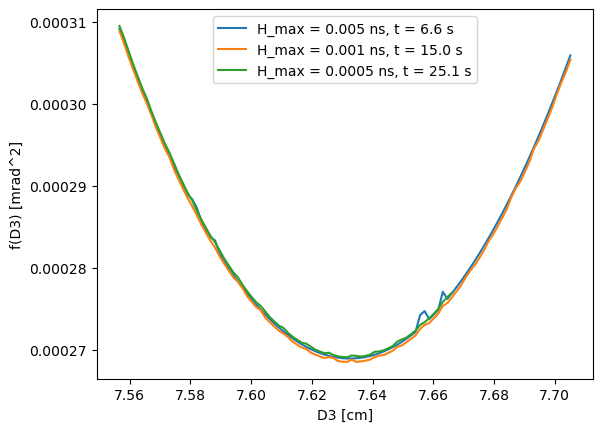

In [50]:
plotStepStudy()

In [51]:
print(D3vals[2], funcVals[2])


[7.556607853936276, 7.558107853936276, 7.559607853936276, 7.561107853936276, 7.562607853936276, 7.564107853936276, 7.565607853936276, 7.567107853936276, 7.5686078539362756, 7.570107853936276, 7.571607853936276, 7.573107853936276, 7.574607853936276, 7.576107853936276, 7.577607853936276, 7.579107853936276, 7.580607853936276, 7.582107853936276, 7.583607853936276, 7.585107853936276, 7.586607853936276, 7.588107853936277, 7.589607853936277, 7.591107853936277, 7.592607853936276, 7.594107853936276, 7.595607853936276, 7.597107853936276, 7.598607853936276, 7.600107853936276, 7.601607853936276, 7.603107853936277, 7.604607853936277, 7.606107853936277, 7.607607853936277, 7.609107853936275, 7.610607853936275, 7.612107853936275, 7.6136078539362755, 7.615107853936276, 7.6166078539362765, 7.6181078539362765, 7.619607853936277, 7.621107853936277, 7.622607853936275, 7.624107853936275, 7.625607853936275, 7.627107853936275, 7.628607853936275, 7.630107853936276, 7.631607853936276, 7.633107853936276, 7.63460

In [52]:
print(D3vals[1], funcVals[1])


[7.556607853936276, 7.558107853936276, 7.559607853936276, 7.561107853936276, 7.562607853936276, 7.564107853936276, 7.565607853936276, 7.567107853936276, 7.5686078539362756, 7.570107853936276, 7.571607853936276, 7.573107853936276, 7.574607853936276, 7.576107853936276, 7.577607853936276, 7.579107853936276, 7.580607853936276, 7.582107853936276, 7.583607853936276, 7.585107853936276, 7.586607853936276, 7.588107853936277, 7.589607853936277, 7.591107853936277, 7.592607853936276, 7.594107853936276, 7.595607853936276, 7.597107853936276, 7.598607853936276, 7.600107853936276, 7.601607853936276, 7.603107853936277, 7.604607853936277, 7.606107853936277, 7.607607853936277, 7.609107853936275, 7.610607853936275, 7.612107853936275, 7.6136078539362755, 7.615107853936276, 7.6166078539362765, 7.6181078539362765, 7.619607853936277, 7.621107853936277, 7.622607853936275, 7.624107853936275, 7.625607853936275, 7.627107853936275, 7.628607853936275, 7.630107853936276, 7.631607853936276, 7.633107853936276, 7.63460